#### python kernel : 3.7.13

In [1]:
import pandas as pd
# import pystan   #pip install cython, pip install "pystan<2.18"
# (pystan.__version__)
from prophet import Prophet    #pip install prophet
import matplotlib.pyplot as plt


/home/ykkim/anaconda3/envs/prophet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#data 불러오기
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

In [3]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
print(data.info(),data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB
None 기준시각           0
직전 15분 사용전력    0
dtype: int64


#이상치 처리(이전 값으로 대체)

In [4]:
# 5100 이하값들은 이전 값들로 대체
import numpy as np
data.loc[(data['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data.isna().sum()


기준시각              0
직전 15분 사용전력    1884
dtype: int64

In [5]:
data=data.fillna(method='ffill')
data.isna().sum()


기준시각           0
직전 15분 사용전력    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


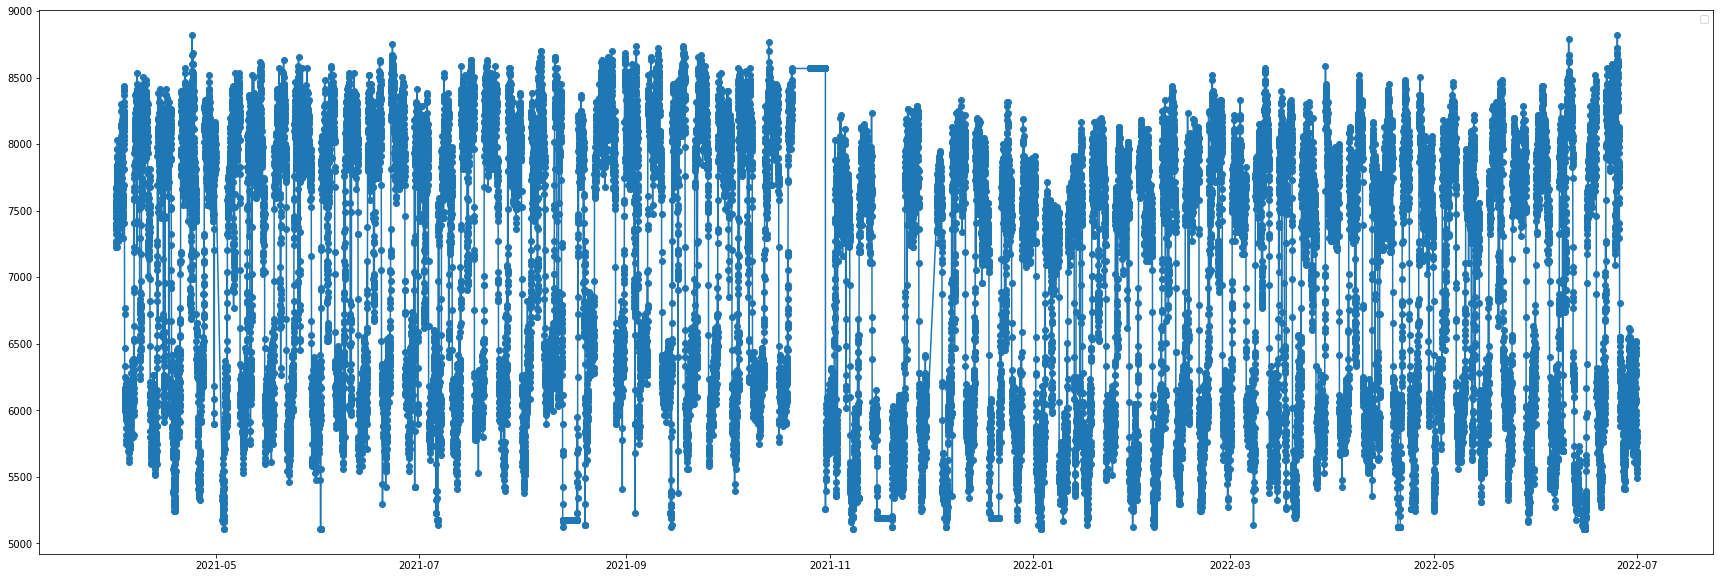

In [6]:
#plot
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data['기준시각'],data['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [7]:
def gen_feature_lag(data,Y_name,feature,i) :  
    # lag data
    data[feature]= data[Y_name].shift(i)   

    return data

def gen_feature_diff(data,Y_name,feature,i) : 
    #diff data
    data[feature]=data[Y_name].diff(i).shift(1)   

    return data

In [8]:
#lag, diff feature 생성
gen_feature_lag(data,'직전 15분 사용전력','l_1',1)
gen_feature_lag(data,'직전 15분 사용전력','l_2',2)
gen_feature_lag(data,'직전 15분 사용전력','l_3',3)
gen_feature_lag(data,'직전 15분 사용전력','l_4',4)
gen_feature_lag(data,'직전 15분 사용전력','l_5',5)


gen_feature_diff(data,'직전 15분 사용전력','d_1',1)
gen_feature_diff(data,'직전 15분 사용전력','d_2',2)


,기준시각,직전 15분 사용전력,l_1,l_2,l_3,l_4,l_5,d_1,d_2
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,7224.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN
3,2021-04-01 00:45:00,7392.0,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4
4,2021-04-01 01:00:00,7576.8,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6
...,...,...,...,...,...,...,...,...,...
42761,2022-06-30 22:45:00,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0
42762,2022-06-30 23:00:00,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6
42763,2022-06-30 23:15:00,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0
42764,2022-06-30 23:30:00,5527.2,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4


In [9]:
def train_test_split(data_t,train_cut_date,val_cut_date,end_time): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)& (data_t['기준시각'] < end_time )] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-30','2022-06-30','2022-06-30 23:00:00')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
# print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42670
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 22:45:00 , 92


In [10]:
df_train.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
# df_val.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)
df_test.rename(columns={"기준시각": "ds", "직전 15분 사용전력": "y"}, inplace=True)

/home/ykkim/anaconda3/envs/prophet/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
#tunning
import itertools
import numpy as np
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

cutoffs = pd.to_datetime(['2021-07-30', '2021-10-30', '2022-02-28'])

param_grid = {  
    'n_changepoints':[25, 50, 75, 100],# CP수
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.05],  #CP추정 민감도
    'seasonality_prior_scale': [10.0, 20.0, 15.0, 30.0], #계절 추정 민감도
    #휴일(holiday)은 고려하지 않음
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='1 days', parallel="processes")   #initial : 학습할 구간 ,horizon : 학습한 것을 바탕으로 예측할 구간, period : cutoff의 간격, train과 val set의 개수를 결정한다.
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

23:57:17 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing
23:57:33 - cmdstanpy - INFO - Chain [1] done processing
23:57:36 - cmdstanpy - INFO - Chain [1] start processing
23:57:44 - cmdstanpy - INFO - Chain [1] done processing
23:58:23 - cmdstanpy - INFO - Chain [1] done processing
23:58:25 - cmdstanpy - INFO - Chain [1] start processing
23:59:01 - cmdstanpy - INFO - Chain [1] done processing
23:59:01 - cmdstanpy - INFO - Chain [1] start processing
23:59:02 - cmdstanpy - INFO - Chain [1] start processing
23:59:13 - cmdstanpy - INFO - Chain [1] done processing
23:59:16 - cmdstanpy - INFO - Chain [1] start processing
23:59:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:05 - cmdstanpy - INFO - Chain [1] done processing
00:00:07 - cmdstanpy - INFO - Chain [1] start processing
00:00:59 - cmdstanpy - INFO - Chain [1] done processing
00:00:59 - cmdstanpy - INFO - Chain [1] 

    n_changepoints  changepoint_prior_scale  seasonality_prior_scale      mape
0               25                    0.001                     10.0  0.063734
1               25                    0.001                     20.0  0.063833
2               25                    0.001                     15.0  0.063825
3               25                    0.001                     30.0  0.063869
4               25                    0.010                     10.0  0.072161
..             ...                      ...                      ...       ...
59             100                    0.100                     30.0  0.076887
60             100                    0.050                     10.0  0.076177
61             100                    0.050                     20.0  0.076317
62             100                    0.050                     15.0  0.076186
63             100                    0.050                     30.0  0.076219

[64 rows x 4 columns]


In [12]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'n_changepoints': 50, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0}


In [11]:
m = Prophet(n_changepoints=50,changepoint_prior_scale= 0.001, seasonality_prior_scale=30.0) # Default growth='linear'

In [12]:
m.fit(df_train)
future = m.make_future_dataframe(periods=4*24,freq = '15min')
forecast=m.predict(future)

07:26:14 - cmdstanpy - INFO - Chain [1] start processing
07:26:21 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(96)

,ds,yhat,yhat_lower,yhat_upper
42670,2022-06-30 00:00:00,7591.416616,6675.120876,8413.927588
42671,2022-06-30 00:15:00,7587.938518,6683.409597,8476.326970
42672,2022-06-30 00:30:00,7585.478476,6742.185311,8452.127121
42673,2022-06-30 00:45:00,7583.798170,6751.584531,8404.838047
42674,2022-06-30 01:00:00,7582.597185,6707.115175,8337.718110
...,...,...,...,...
42761,2022-06-30 22:45:00,7513.005318,6633.964139,8381.168953
42762,2022-06-30 23:00:00,7516.226323,6693.311092,8348.021505
42763,2022-06-30 23:15:00,7520.535360,6668.120611,8364.756102
42764,2022-06-30 23:30:00,7526.108866,6652.984600,8402.112614


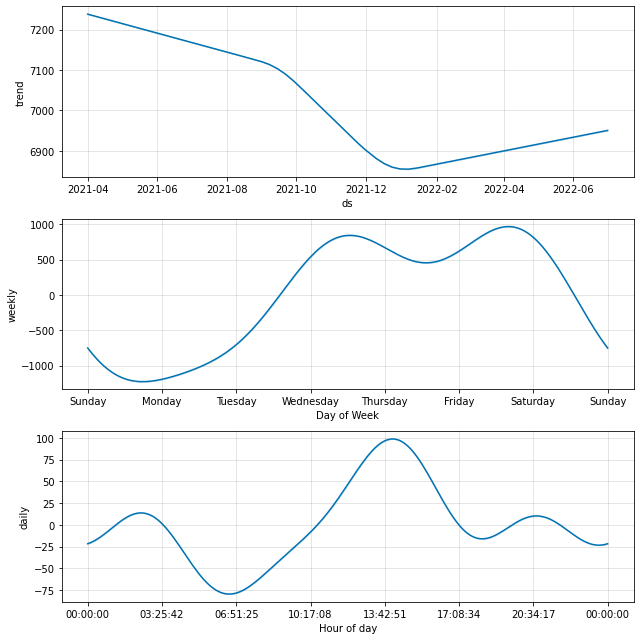

In [13]:
fig2 = m.plot_components(forecast)

In [14]:
result_df=pd.merge(df_test,forecast,how='left',on='ds')


Text(0.5, 1.0, 'moorim_demand')

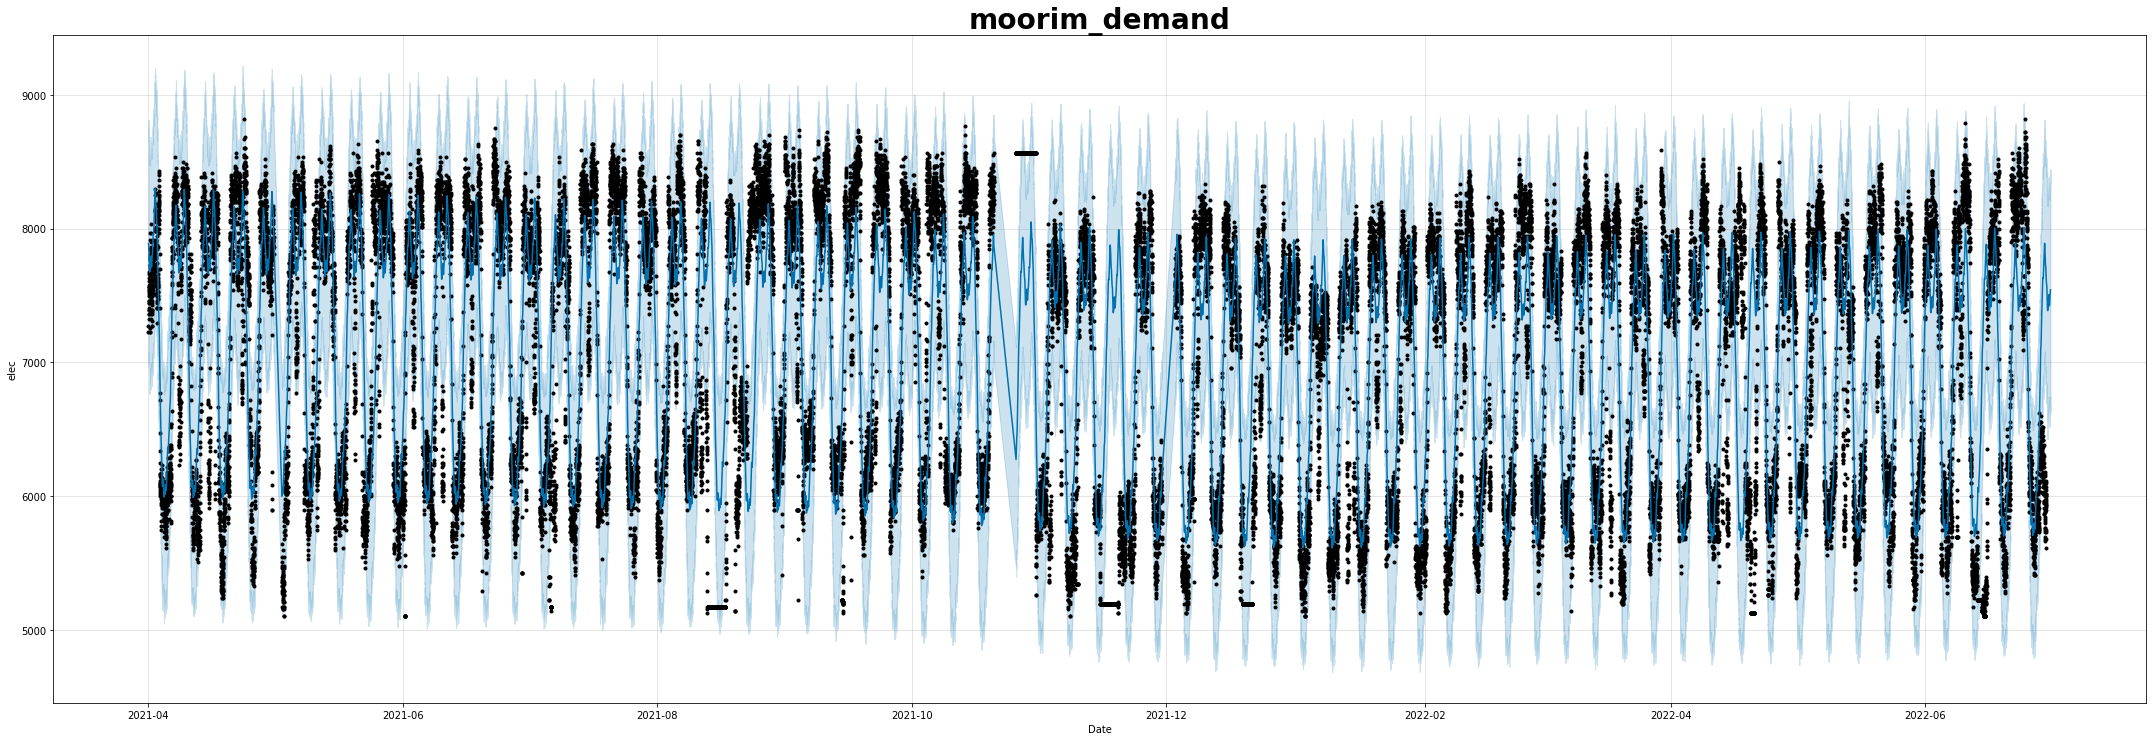

In [15]:
#  fig1, ax = plt.subplots(figsize=(14, 10)) 
fig, ax = plt.subplots(figsize=(30, 10)) 
m.plot(forecast, xlabel="Date", ylabel="elec", ax=ax)
ax.set_title("moorim_demand", fontsize=28, fontweight="bold")


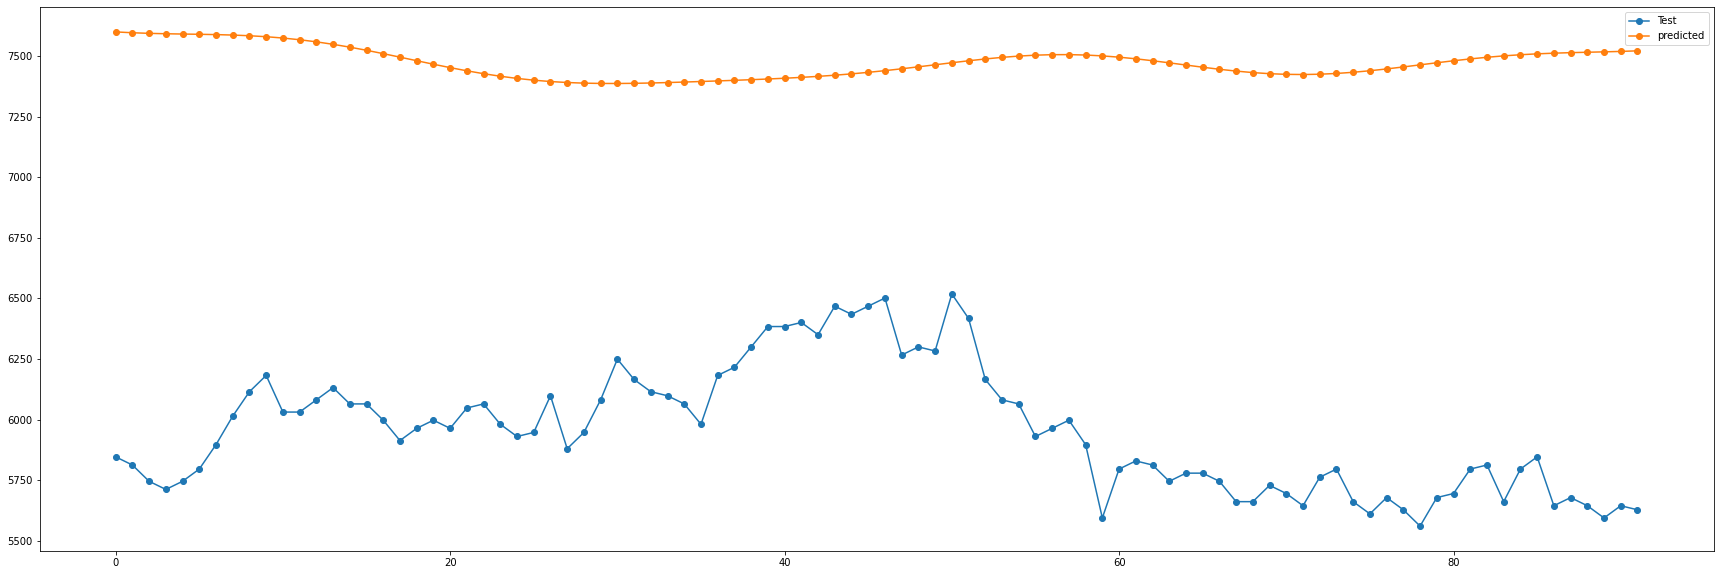

In [16]:
def predict_graph(test,prediction) : 
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)   
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(result_df['y'],result_df['yhat'])

In [18]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(result_df['y'], result_df['yhat'])

0.2569245549015503

In [18]:
# # model save to disk
# import pickle

# filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try1.sav'
# pickle.dump(model, open(filename, 'wb'))